# Plot of first run of `ota-basic.py`

_6 to 9 July 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

These plots are the first nontrivial run of the over-the-air experiments. I'm not expecting them to say much, but hopefully they offer something not too unexpected.

In [1]:
import json
import random
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plots_utils import fits_spec, get_args, get_eval, show_timestamp_info, plot_averaged_training_charts

# Training by round

First, let's just pick a few cases and plot the training graphs for them.

In [2]:
results_location = Path("../results-downloaded/ota-basic-1")
show_timestamp_info(results_location)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **05 Jul 2021, 23:47:39** | 06 Jul 2021, 00:00:36 | 12 min 57 s |
| last to finish | 07 Jul 2021, 05:34:21 | **07 Jul 2021, 05:47:32** | 13 min 11 s |
| shortest | 06 Jul 2021, 04:19:50 | 06 Jul 2021, 04:32:15 | **12 min 25 s** |
| longest | 07 Jul 2021, 02:32:48 | 07 Jul 2021, 02:49:04 | **16 min 15 s** |


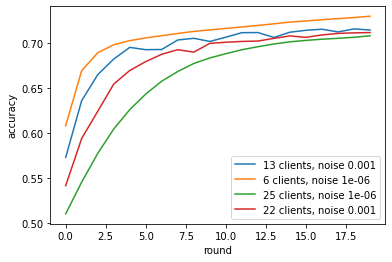

In [3]:
directories = random.sample(list(results_location.iterdir()), 4)

for directory in directories:
    args = get_args(directory)
    clients = args['clients']
    noise = args['noise']

    training = pd.read_csv(directory / "training.csv")
    training["accuracy"].plot(label=f"{clients} clients, noise {noise}", xlabel="round", ylabel="accuracy")

plt.legend()

Seems like all the low-noise cases did better than all the high-noise cases. That seems promising. Is that right? In the below plot, blue (`'C0'`) lines are $\sigma_\mathrm{n}^2 = 1.0$, orange (`'C1'`) lines are $\sigma_\mathrm{n}^2 = 0.001$ and green (`'C2'`) lines are $\sigma_\mathrm{n}^2 = 10^{-6}$.

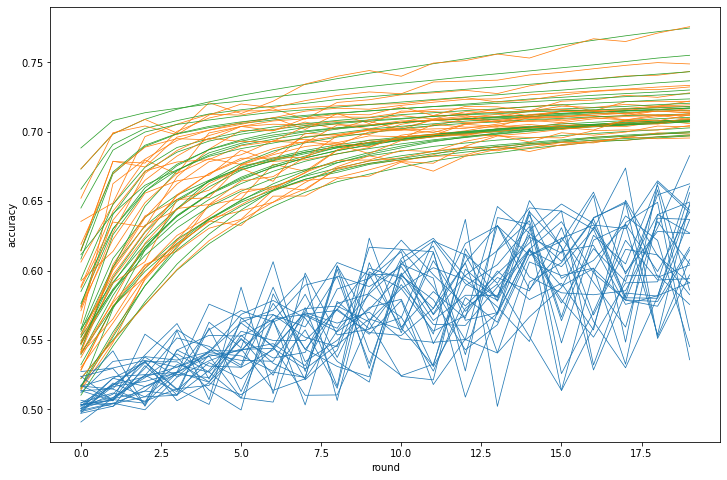

In [4]:
for directory in results_location.iterdir():
    args = get_args(directory)
    noise = args['noise']
    color = {1.0: 'C0', 0.001: 'C1', 1e-6: 'C2'}[noise]
    training = pd.read_csv(directory / "training.csv")
    # thinner lines (0.75 pt) because there are lots of lines
    training["accuracy"].plot(figsize=(12, 8), ylabel="accuracy", xlabel="round", color=color, linewidth=0.75)

Seems pretty legit. Notice also that the high-noise cases jump around heaps, but do improve eventually. This also seems consistent with what we'd expect.

# Test accuracy vs clients

In [5]:
clients_range = range(2, 31)
noise_levels = [1e-6, 0.001, 1.0]
fields = ["accuracy", "snr", "avg_power", "test_loss"]
columns = pd.MultiIndex.from_product((fields, noise_levels))

results = pd.DataFrame(index=clients_range, columns=columns)

for directory in results_location.iterdir():
    args = get_args(directory)
    clients = args['clients']
    noise = args['noise']
    
    evaluation = get_eval(directory)
    for field in fields:
        results.loc[clients, (field, noise)] = evaluation[field]

In [6]:
# inspect the table just to make sure it looks okay
results.head()

accuracy                             snr                      avg_power  \
  0.000001 0.001000 1.000000      0.000001   0.001000  1.000000  0.000001   
2  0.77472   0.7757  0.58268  10789.862901  10.821012  0.010789   0.01079   
3  0.75509  0.74887  0.64937   5394.470511   5.401468  0.005319  0.005394   
4  0.74326  0.74343  0.53578   3263.636542   3.249207  0.003241  0.003264   
5  0.73673  0.73344  0.62676   2215.206453   2.171026  0.002184  0.002215   
6   0.7301  0.73229  0.59692   1615.790227   1.628625   0.00167  0.001616   

                      test_loss                      
   0.001000  1.000000  0.000001  0.001000  1.000000  
2  0.010821  0.010789  0.604237  0.604292  0.698372  
3  0.005401  0.005319  0.627342  0.627399  0.645233  
4  0.003249  0.003241  0.640813  0.640866  0.670373  
5  0.002171  0.002184  0.649608  0.649957  0.659625  
6  0.001629   0.00167  0.655891  0.655859  0.664952

<AxesSubplot:xlabel='clients', ylabel='accuracy'>

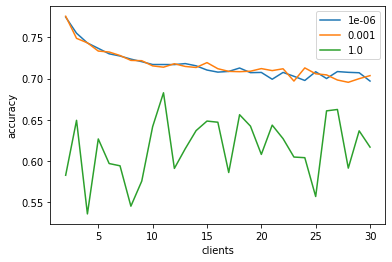

In [7]:
results["accuracy"].plot(xlabel="clients", ylabel="accuracy")

Okay, that's interesting—it seems to go better with _fewer_ clients. This is the opposite of what we should expect. What's going on?

One issue is that the quality of our "data"—in this case, the local model parameters—gets worse as we have more clients, because each client has less data (because the data is split up among clients). The easy way around this is to divide the data ahead of time into the largest number of clients we intend to test, and then only use some of the data when there are fewer clients.

But possibly the bigger problem is that our SNR function is actually a function of the number of clients:

<AxesSubplot:xlabel='clients', ylabel='SNR'>

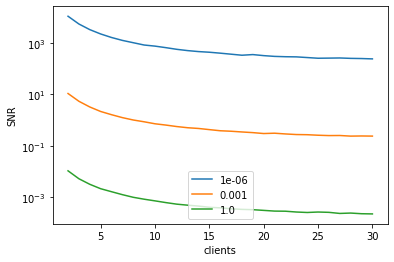

In [8]:
results["snr"].plot(xlabel="clients", ylabel="SNR", logy=True)

Forget about noise, what about just plotting the average power?

<AxesSubplot:xlabel='clients', ylabel='average power'>

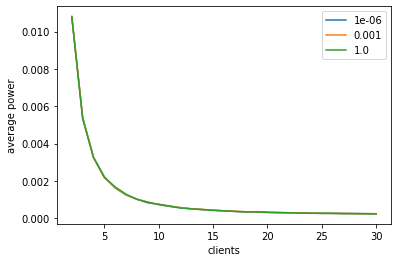

In [9]:
results["avg_power"].plot(xlabel="clients", ylabel="average power")

What the what? There's no division by the number of clients, and the symbols being transmitted are the model state. (The field `avg_power` reflects the average power coming out of a transmitter, not the total power in the system, so there's no multiplication by the number of clients, either.)

Questions:
- Is the average power a function of round number?
- What are the final model states?

These are kind of things I wish I had logged.

# Why is the average power a function of the number of clients?

[8 July]

I modified the script to log the actual models every round, and the transmit power for every client in every round. Maybe this'll give some insight.

What does the transmit power do? Here's 2, 3, 7, 16 and 30 clients:

In [10]:
results_location = Path("../results-downloaded/ota-basic-2")
show_timestamp_info(results_location)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **06 Jul 2021, 23:17:03** | 06 Jul 2021, 23:29:37 | 12 min 33 s |
| last to finish | 07 Jul 2021, 05:43:03 | **07 Jul 2021, 05:56:43** | 13 min 39 s |
| shortest | 07 Jul 2021, 02:04:58 | 07 Jul 2021, 02:17:31 | **12 min 32 s** |
| longest | 07 Jul 2021, 02:47:26 | 07 Jul 2021, 03:03:22 | **15 min 55 s** |


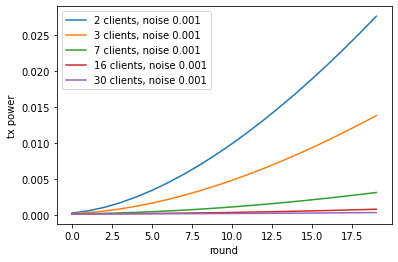

In [11]:
directories = ["20210706-231703", "20210706-232938", "20210707-002120", "20210707-021733", "20210707-054303"]
directories = [results_location / directory for directory in directories]

for directory in directories:
    args = get_args(directory)
    clients = args['clients']
    noise = args['noise']

    training = pd.read_csv(directory / "training.csv")
    training["tx_power_client0"].plot(label=f"{clients} clients, noise {noise}", 
                                      xlabel="round", ylabel="tx power")

plt.legend()

Okay, so it's definitely not constant with respect to round. That's kinda weird, because I'm not sure what it could depend on other than the model parameters themselves.

In [12]:
def get_model_params(directory):
    """Figures out weight norms and the bias from the model_at_<n>.json files
    in the given `directory, and returns a DataFrame containing them, indexed
    by round/epoch number. `directory` must be a pathlib.Path object."""
    model_params = pd.DataFrame()
    for child in directory.iterdir():
        m = re.match("model_at_(\d+).json", child.name)
        if not m:
            continue
        with open(child) as f:
            model_dict = json.load(f)
        r = int(m.group(1))
        weights = np.array(model_dict['stack.0.weight'])
        model_params.loc[r, 'weight_norm'] = np.linalg.norm(weights, ord=2)
        model_params.loc[r, 'bias'] = model_dict['stack.0.bias'][0]
        
    return model_params.sort_index()

<AxesSubplot:title={'center':'2 clients'}, xlabel='round'>

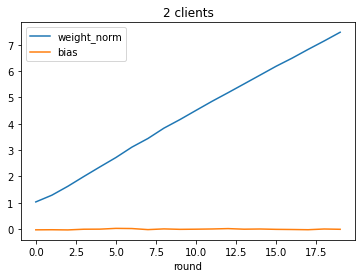

In [13]:
directory = results_location / "20210706-231703"
args = get_args(directory)
model_params = get_model_params(directory)
model_params.plot(title=f"{args['clients']} clients", xlabel="round")

Okay, those weights are definitely getting larger. And it doesn't seem to the bias, or at least not the bias specifically, though it's not too hard to imagine that it might be the bias in another dataset.

Just checking, this depends on the number of clients, right?

<AxesSubplot:>

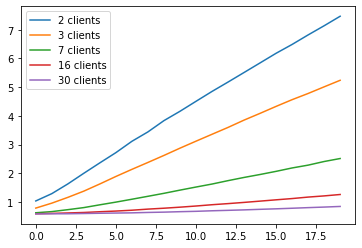

In [14]:
weight_norms = pd.DataFrame()

for directory in directories:
    args = get_args(directory)
    clients = args['clients']
    model_params = get_model_params(directory)
    weight_norms[f"{clients} clients"] = model_params["weight_norm"]

weight_norms.plot()

Yup.

Also, I'll be there's some correlation between this figure, the weight norm, and accuracy. Or even just transmit power and accuracy. (The weight norm is very obviously related to the transmit power, though the weight norm relates to the global model, and the transmit power to the client models, the relationship isn't one-to-one.) Maybe?

<AxesSubplot:title={'center':'accuracy vs tx power at client 0'}, xlabel='tx_power_client0', ylabel='accuracy'>

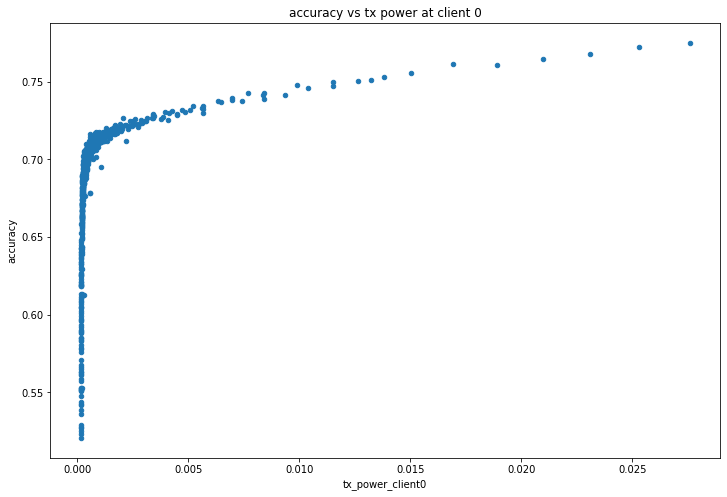

In [15]:
all_points = pd.DataFrame()
for directory in results_location.iterdir():
    training = pd.read_csv(directory / "training.csv")
    all_points = all_points.append(training[["accuracy", "tx_power_client0"]])
all_points.plot.scatter(x="tx_power_client0", y="accuracy", 
                        title="accuracy vs tx power at client 0", figsize=(12, 8))

Maybe that weight norm thing will be more enlightening.

<AxesSubplot:title={'center':'accuracy vs weights norm'}, xlabel='weight_norm', ylabel='accuracy'>

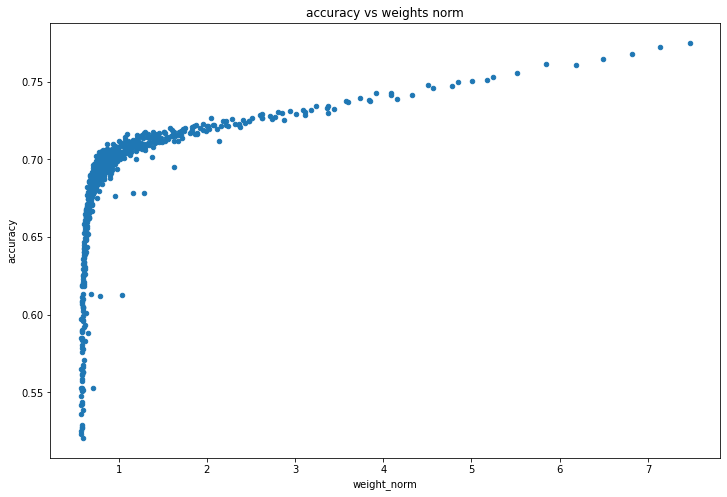

In [16]:
all_points = pd.DataFrame()

for directory in results_location.iterdir():
    training = pd.read_csv(directory / "training.csv")
    model_params = get_model_params(directory)
    training["weight_norm"] = model_params["weight_norm"]
    all_points = all_points.append(training[["accuracy", "weight_norm"]])
    
all_points.plot.scatter(x="weight_norm", y="accuracy", title="accuracy vs weights norm", figsize=(12, 8))

Okay, I guess that arguably supports my hypothesis. But it's not that convincing. What if we separate these by color, one color for each number of clients? And put lines in, so we can see the trajectory. Let's just do it from 2 clients to 11 clients, to avoid clutter.

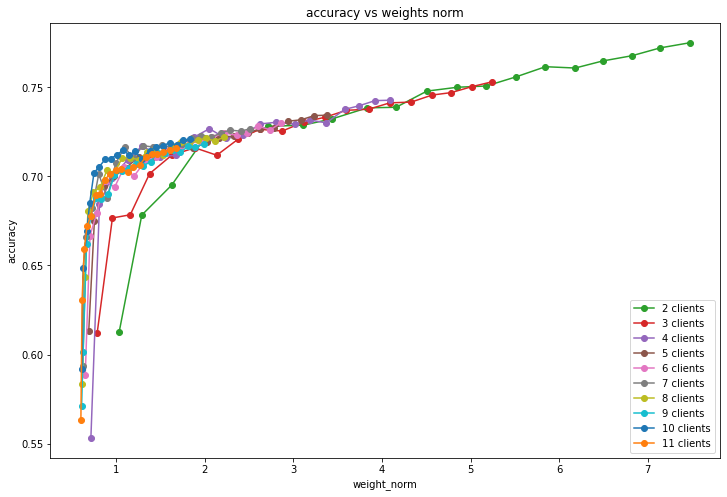

In [17]:
fig, ax = plt.subplots()

for directory in sorted(results_location.iterdir())[:10]:
    args = get_args(directory)
    clients = args['clients']
    
    training = pd.read_csv(directory / "training.csv")
    model_params = get_model_params(directory)
    training["weight_norm"] = model_params["weight_norm"]
    training.plot(ax=ax, x="weight_norm", y="accuracy", label=f"{clients} clients",
                  title="accuracy vs weights norm", color=f'C{clients}',
                  marker='o', figsize=(12, 8), ylabel="accuracy")

plt.legend()

Okay, I think I'm broadly prepared to call that "tx power increases _because_ accuracy increases". That seems like the most plausible explanation. This creates a bit of a problem, because it's not really clear to me what the maximum would be. Like, if you're subject to a power constraint, how do you set the scaling factor if you don't know the parameter radius?

# What is the actual solution?

In this case, a rather blunt tool would be to train the logistic model "normally" and figure out what the "actual" model is. Since it's just logistic regression I think the loss function should be (at least quasi-)convex, so hopefully idea is coherent if nothing else.

I ran vanilla SGD (no federated anything) with 4000 epochs to see how it would go.

In [18]:
vanilla_location = Path("../results-downloaded/logistic-vanilla-long")
show_timestamp_info(vanilla_location)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **08 Jul 2021, 03:25:51** | 08 Jul 2021, 12:58:59 | 9 h 33 min 08 s |
| last to finish | 08 Jul 2021, 14:32:52 | **09 Jul 2021, 05:18:07** | 14 h 45 min 14 s |
| shortest | 08 Jul 2021, 03:25:51 | 08 Jul 2021, 12:58:59 | **9 h 33 min 08 s** |
| longest | 08 Jul 2021, 14:32:52 | 09 Jul 2021, 05:18:07 | **14 h 45 min 14 s** |


Text(0.5, 1.0, 'accuracy')

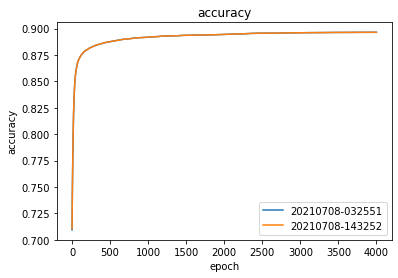

In [19]:
for directory in vanilla_location.iterdir():
    args = get_args(directory)
    training = pd.read_csv(directory / "training.csv")
    training["accuracy"].plot(label=directory.name, xlabel="epoch", ylabel="accuracy")
plt.legend()
plt.title("accuracy")

Text(0.5, 1.0, 'weight norm')

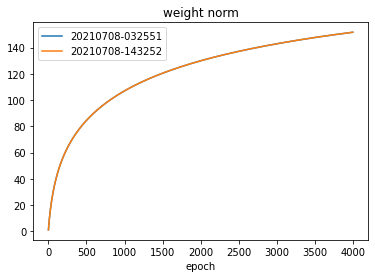

In [20]:
for directory in vanilla_location.iterdir():
    model_params = get_model_params(directory)
    model_params["weight_norm"].plot(label=directory.name, xlabel="epoch")
plt.legend()
plt.title("weight norm")

Text(0.5, 1.0, 'bias')

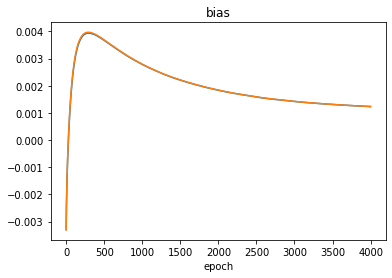

In [21]:
for directory in vanilla_location.iterdir():
    model_params = get_model_params(directory)
    model_params["bias"].plot(label=directory.name, xlabel="epoch")
plt.title("bias")

Seems like we finish with a weight norm of around 152, and that bias won't add very much. So if we were going to attempt to scale this "properly", we'd set $B\sqrt d \approx 152$, or $B \approx 3.4$. And we'd just set this as a constant.

The average power would vary with the round and the number of clients, because it would only approx maximum power as the model neared (good) convergence, but we'd be assured that it's always within the actual power limit.

Let's just take a sneak peek at the weights:

bias [0.001231784583069384]
bias [0.0012344463029876351]


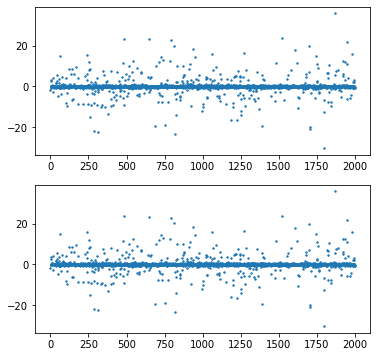

In [22]:
plt.figure(figsize=(6, 6))
for i, directory in enumerate(vanilla_location.iterdir()):
    plt.subplot(2, 1, i+1)
    with open(directory / "model_at_3999.json") as f:
        model_dict = json.load(f)
    plt.scatter(range(2000), model_dict['stack.0.weight'], s=2)
    print("bias", model_dict['stack.0.bias'])

Note that these weights look pretty similar, which should offer some confidence that this is the actual solution, not just a local minimum (as we would hope for such a simple problem).

By the way, what does the accuracy vs weight norm curve look like?

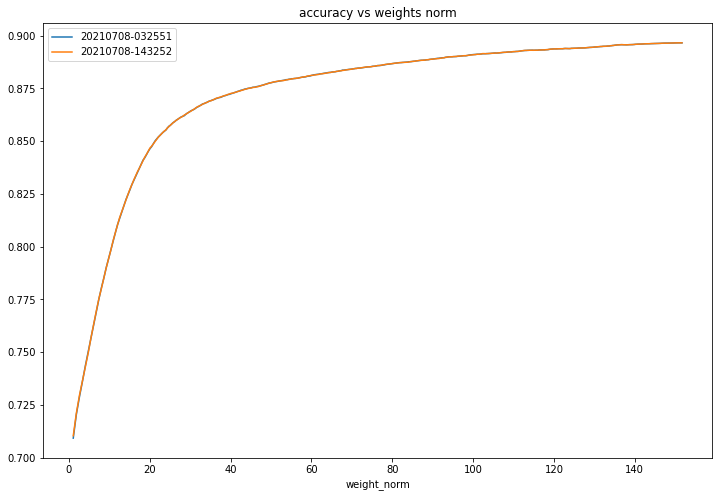

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
for directory in vanilla_location.iterdir():
    args = get_args(directory)
    training = pd.read_csv(directory / "training.csv")
    model_params = get_model_params(directory)
    training["weight_norm"] = model_params["weight_norm"]
    training.plot(ax=ax, x="weight_norm", y="accuracy", title="accuracy vs weights norm", label=directory.name)

In [24]:
training.loc[5:6]

,epoch,timestamp,accuracy,test_loss,train_loss,weight_norm
5,5,2021-07-08T14:42:46.262322,0.74981,0.632651,0.620698,4.778876
6,6,2021-07-08T14:42:55.983864,0.75697,0.624960,0.611352,5.461846


In [25]:
training.tail()

,epoch,timestamp,accuracy,test_loss,train_loss,weight_norm
3995,3995,2021-07-09T05:17:30.912277,0.89657,0.261648,0.192571,151.666558
3996,3996,2021-07-09T05:17:39.423266,0.89656,0.261646,0.192571,151.674018
3997,3997,2021-07-09T05:17:47.868291,0.89656,0.261645,0.192571,151.681476
3998,3998,2021-07-09T05:17:56.566439,0.89655,0.261644,0.192571,151.688929
3999,3999,2021-07-09T05:18:05.686442,0.89654,0.261642,0.192571,151.696378


Of note from this curve: If accuracy only gets up to about 0.75, then the weight norm will be about 5, which is about 1/30 of its eventual value after 4000 epochs. This, in term, means that transmit power will be about $\frac{1}{30^2} \approx 0.0011$ of its eventual value. It's worth keeping this in mind—we will not really be able to set the parameter radius to do actually what we want, which is to hit a power of $P$ when it gets close to convergence, because it probably won't get close to convergence.

# What if we keep data per client, as opposed to total data, constant?

But this leaves open the underlying problem. If the causation is that way round, then why do we end up worse off with more clients?

Well, the function `client_train()` (in `ota-basic.py`) does go through the entire dataloader, so it's true that when there are only two clients, each model is trained better in each round. But the _total_ data used _in the system_ is the same. And it seems a bit silly to have a _double_ advantage from having more clients—both more data, and more power, right?

In [26]:
results_location = Path("../results-downloaded/ota-basic-3/")
show_timestamp_info(results_location)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **08 Jul 2021, 16:41:07** | 08 Jul 2021, 16:57:17 | 16 min 09 s |
| last to finish | 13 Jul 2021, 11:25:40 | **13 Jul 2021, 11:40:28** | 14 min 48 s |
| shortest | 12 Jul 2021, 04:28:50 | 12 Jul 2021, 04:39:28 | **10 min 37 s** |
| longest | 12 Jul 2021, 09:51:21 | 12 Jul 2021, 10:23:36 | **32 min 14 s** |


In [27]:
clients_range = range(2, 31)
noise_levels = ["σₙ²=0.0", "σₙ²=0.001", "σₙ²=0.01", "σₙ²=0.1", "B=3.4"]
fields = ["accuracy", "snr", "avg_power", "test_loss"]
columns = pd.MultiIndex.from_product((fields, noise_levels))

results = pd.DataFrame(index=clients_range, columns=columns)

for directory in results_location.iterdir():
    args = get_args(directory)
    clients = args['clients']
    
    if args['data_per_client'] != 13333:
        continue
    elif args['noise'] in [0, 0.001, 0.01, 0.1]:
        assert args['parameter_radius'] == 1.0
        noise_level = "σₙ²=" + str(args['noise'])
    elif args['parameter_radius'] == 3.4:
        assert args['noise'] == 1.0
        noise_level = "B=3.4"
    else:
        assert False, "huh?"
    
    evaluation = get_eval(directory)
    for field in fields:
        results.loc[clients, (field, noise_level)] = evaluation[field]

In [28]:
results.head()

accuracy                                          snr                      \
   σₙ²=0.0 σₙ²=0.001 σₙ²=0.01  σₙ²=0.1    B=3.4 σₙ²=0.0 σₙ²=0.001  σₙ²=0.01   
2   0.7054   0.70459  0.57848  0.53018  0.50863     inf  0.246257  0.023827   
3  0.68535   0.65463  0.65011  0.50976  0.49731     inf  0.230505  0.023141   
4  0.68887   0.68961  0.64039  0.58155  0.50276     inf  0.227486  0.022575   
5  0.70201   0.66156  0.67229  0.52105  0.51329     inf  0.242795  0.023319   
6  0.70848   0.69168  0.65611  0.59186  0.50105     inf  0.235793  0.024165   

                      avg_power                                          \
    σₙ²=0.1     B=3.4   σₙ²=0.0 σₙ²=0.001  σₙ²=0.01   σₙ²=0.1     B=3.4   
2  0.002493  0.000021  0.000228  0.000246  0.000238  0.000249  0.000021   
3  0.002321  0.000021  0.000234  0.000231  0.000231  0.000232  0.000021   
4    0.0024   0.00002  0.000235  0.000227  0.000226   0.00024   0.00002   
5  0.002333  0.000021  0.000231  0.000243  0.000233  0.000233  0.000021   
6  0.002395  0.000021  0.000237  0.000236  0.000242   0.00024  0.000021   

  test_loss                                          
    σₙ²=0.0 σₙ²=0.001  σₙ²=0.01   σₙ²=0.1     B=3.4  
2  0.684723  0.684429  0.685897   0.69073  1.279494  
3  0.684568   0.68477  0.685032  0.691809  0.805813  
4  0.684526  0.684424  0.684754  0.685128  0.788127  
5  0.684634   0.68446  0.684987  0.686736  0.721444  
6  0.684526   0.68469  0.684441  0.684654  0.728396

<AxesSubplot:title={'center':'13,333 examples per client'}, xlabel='clients', ylabel='accuracy'>

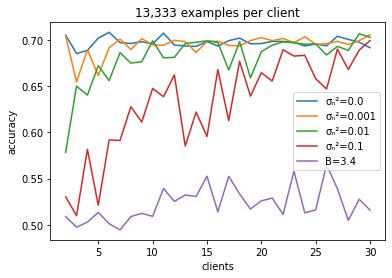

In [29]:
results["accuracy"].plot(xlabel="clients", ylabel="accuracy", title="13,333 examples per client")

Let's go back to the first section and remind ourselves what was going on. When we plotted the average power vs number of clients, we found that average power was a _decreasing function_ of the number of clients. That is, the more clients we had, the less power got used. This seemed odd, so I dug a little deeper by looking at the tx power _per round_. There, we found that tx power was an increasing function of round number, and moreover that the fewer clients there were, the _faster_ tx power increased. Then, we looked at tx power vs accuracy, and found that the better the weights were trained, the higher tx power was. At some level this probably because the weights start close to zero, then approach their final values with more training. And with fewer clients, there were more data points per client, so each client trained better and got more accurate, and in turn sent in a more accurate estimate, which consumed more power. So in summary: if you split data among fewer clients, each client trains faster, and more accurate models transmit more power as the weights reach their optimum.

Now, if we hold the data _per client_ constant, it seems like at sufficiently low noise levels, the number of clients just doesn't really matter. But $\sigma_\mathrm{n} = 0.1$, we see performance rise with the number of clients, as we'd expect. At $B = 3.4, \sigma_\mathrm{n}=1$, things seem broadly useless.

So this makes it seem like "keep data per client constant" is the better idea than "split the same amount of data among clients". But here we have a problem: Under this model, the more clients we have, the more data we have. Couldn't the improvement in accuracy just be an artifact of having more data?

To do some time:
- We should probably run it with zero noise just to give a baseline. (Do this tonight.)
- We should probably average this over multiple runs. I think we need to build out the framework to do this, though.

# Did the $B = 3.4$ idea work?

Another idea we were trying out was that if we set $B$ to the right level, the power transmitted should be at the right level. In particular, increasing $B$ should reduce the ratio by which the model weights are scaled down before transmission, basically increasing transmit power by the same factor. So the idea here was that, if we set $B$ to the right level, the transmit power should be close to $P$, which in all the simulations we've run so far was 1.

How did that go?

_Changed on 23 July: All theese plots used to use an older `plot_training_charts()` function that only plotted individual series; now that `plot_averaged_training_charts()` exists, these cells now use that function, even though they're only averaging a single series (so it's a bit overkill)._

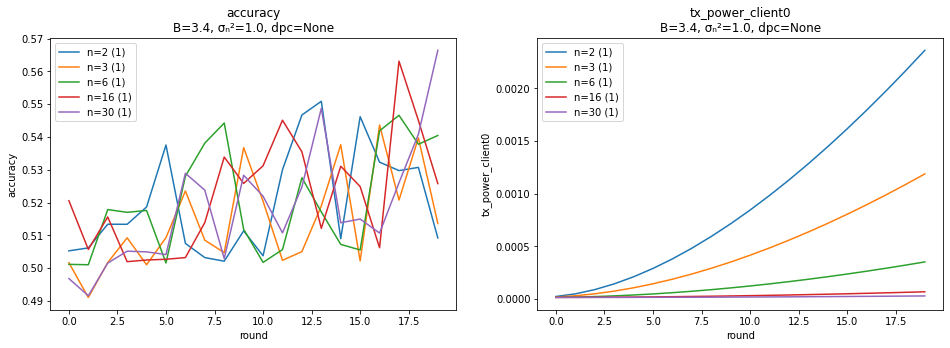

In [30]:
fields = ["accuracy", "tx_power_client0"]
title_specs = {'parameter_radius': 3.4, 'noise': 1.0, 'data_per_client': None}
fixed_specs = {'power': 1, 'batch_size': 64, 'rounds': 20, 'dataset': 'epsilon', 'lr_client': 1e-2}
series_specs = {'clients': [2, 3, 6, 16, 30]}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

Well, that's a shambles. I guess that's a nice way of observing the noise is way, way too large to be meaningful here. Maybe we ought to give it a go with very little noise, or no noise.

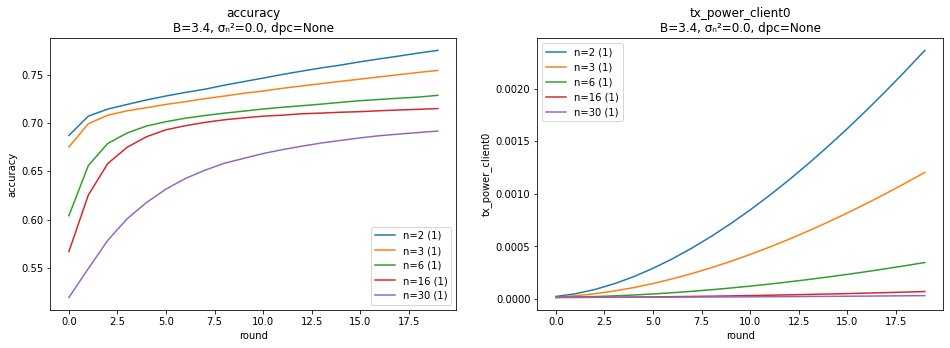

In [31]:
title_specs['noise'] = 0.0
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

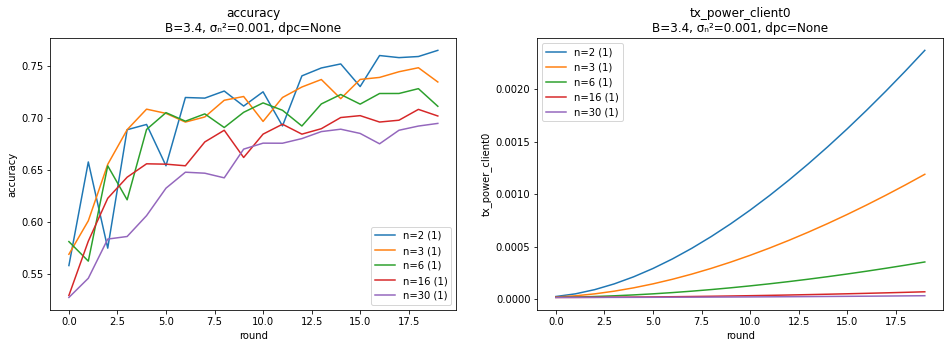

In [32]:
title_specs = {'parameter_radius': 3.4, 'noise': 0.001, 'data_per_client': None}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

Okay, that's broadly what we expected, I guess. The $B = 3.4$ didn't do very much, but we know why that is—it's not training to anywhere near convergence, and we know from the accuracy vs weight norm chart above that at accuracy 0.75, we're only looking at around 0.0011 times the maximum power. We're actually seeing a little bit more than that, though I'm not sure why and I'm not convinced this will end up being anything more than cosmetic.

# Constant data per client at different noise levels

Though, I wonder what the "constant data per client" charts look like?

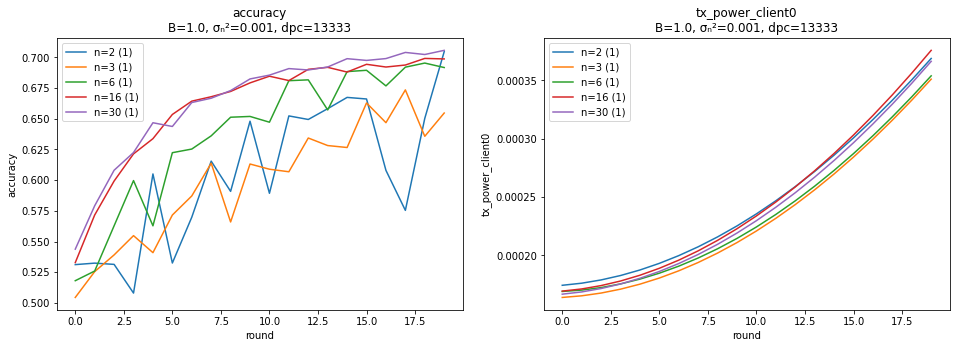

In [33]:
title_specs = {'parameter_radius': 1.0, 'noise': 0.001, 'data_per_client': 13333}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

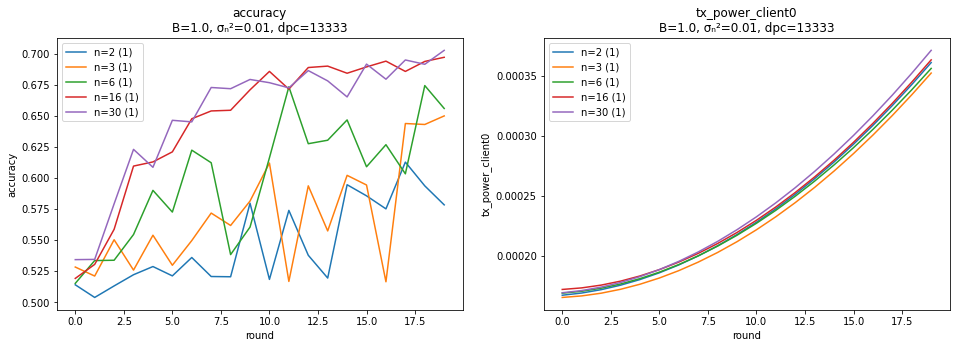

In [34]:
title_specs = {'parameter_radius': 1.0, 'noise': 0.01, 'data_per_client': 13333}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

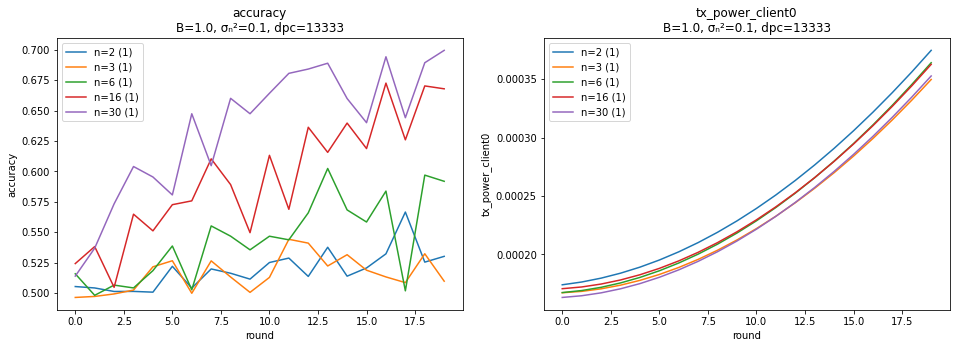

In [35]:
title_specs = {'parameter_radius': 1.0, 'noise': 0.1, 'data_per_client': 13333}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

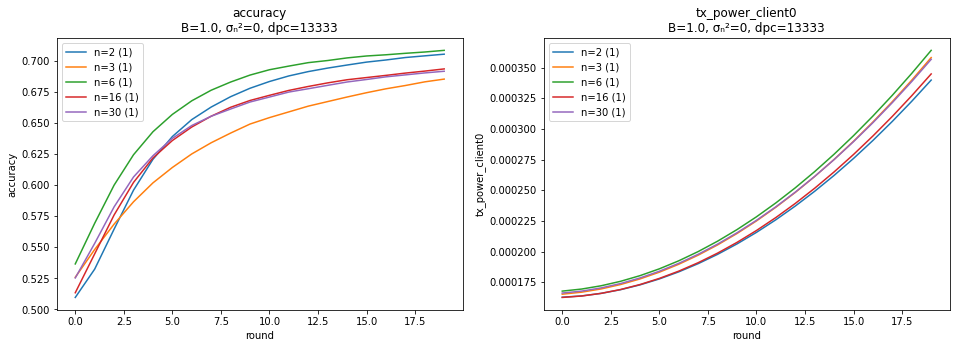

In [36]:
title_specs = {'parameter_radius': 1.0, 'noise': 0, 'data_per_client': 13333}
plot_averaged_training_charts(results_location, fields, title_specs, fixed_specs, series_specs)

Seems like the expected effect of noise. We'll need to run many simulations and take the average to get a less noisy graph.